# PII DI (Document Identification )

The first task here is to classify the unique government issued documents. Here is a list : 

1. Aadhaar card, a biometric, digital and physical identity system.
2. Indian passport
3. Overseas Passport
4. Electoral Photo Identity Card (EPIC) issued by the Election Commission of India
5. Permanent account number (PAN) card (income tax)
6. Driving license in India issued by the states
7. Ration card issued by the Government of India
8. A Birth certificate issued by the Registry of Births and Deaths (RBD) or from a Municipality within the provisions of the RBD Act
9. Policy Bond issued by Public Life Insurance Corpor
10. Gas bill


`Some Literature around it` : 

- https://analyticsindiamag.com/extraction-of-aadhar-ids-using-opencv-tensorflow-sushil-ostwal-head-data-science-at-motilal-oswal-financial-services/
- https://medium.com/cashify-engineering/improve-accuracy-of-ocr-using-image-preprocessing-8df29ec3a033

`Resource around installing pytesseract in Ubuntu`
- https://www.linux.com/training-tutorials/using-tesseract-ubuntu/

In [ ]:
import os
from glob import glob
import datetime
import traceback

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!tesseract -v

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 17 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,565 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
!pip install pytesseract
import pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=85a0c1bb050d74198e618abc7a2d987f4abcf7ce60f6fb34164689cc5a3bd883
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#drive.mount('/PII Project/data', force_remount=True)
import os
os.chdir('drive/MyDrive/PII Proejct')

Mounted at /content/drive


In [ ]:
### Using Easy OCR
# import easyocr
# reader = easyocr.Reader(['en']) 

In [ ]:
import cv2
import numpy as np
import tempfile
from PIL import Image
import imutils
import pytesseract

import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
# pytesseract.pytesseract.tesseract_cmd  = r'C:\Program Files\Tesseract-OCR\tesseract'

In [ ]:
### centric to pytesseract
def tesseratc_engine(image):
    custom_oem_psm_config = r'--oem 3 --psm 11'
    return pytesseract.image_to_string(image, config=custom_oem_psm_config)

def set_image_dpi(file_path):
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
#     temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
#     temp_filename = temp_file.name
    im_resized.save('improved.png', dpi=(300, 300))
#     return temp_filename


def skew_correction(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(gray, 10, 50)
        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] #if imutils.is_cv2() else cnts[1]
#         contours = contours[0] if imutils.is_cv2() else contours[1]
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
        screenCnt = None
        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                screenCnt = approx
                break

        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    except Exception as e:
        traceback.print_exc()
        return image , cnts
    return image, screenCnt

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, 88, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smooth(img):
    _, thresh = cv2.threshold(img, kmeans(input_img=img, k=8, i_val=2)[0], 255, cv2.THRESH_BINARY)
#     filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
#     kernel = np.ones((1, 1), np.uint8)
#     opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
#     closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#     img = image_smoothening(img)
#     or_image = cv2.bitwise_or(img, closing)
    return thresh

def kmeans(input_img, k, i_val):
    hist = cv2.calcHist([input_img],[0],None,[256],[0,256])
    img = input_img.ravel()
    img = np.reshape(img, (-1, 1))
    img = img.astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(img,k,None,criteria,10,flags)
    centers = np.sort(centers, axis=0)

    return centers[i_val].astype(int), centers, hist

data/3.jpg 3.jpg
uint8
data/7.jpg 7.jpg
uint8
data/4.jpg 4.jpg
uint8
data/1.jpg 1.jpg
uint8
data/6.jpg 6.jpg
uint8
data/2.jpg 2.jpg
uint8
data/5.jpg 5.jpg
uint8
data/Incorrect Name.jpg Incorrect Name.jpg
uint8
data/Incorrect details -1.jpg Incorrect details -1.jpg
uint8
data/No details extracted.jpg No details extracted.jpg
uint8
data/10049027336340_DrivingLicence.jpg 10049027336340_DrivingLicence.jpg
uint8
data/10006989389712_VoterID.jpg 10006989389712_VoterID.jpg
uint8
data/10018765037077_VoterID.jpg 10018765037077_VoterID.jpg
uint8
data/10057927394633_VoterID.jpg 10057927394633_VoterID.jpg
uint8
data/20024075943716_AadharCard.jpg 20024075943716_AadharCard.jpg
uint8
data/40089856771173_VoterID.jpg 40089856771173_VoterID.jpg
uint8
data/30056250280226_VoterID.jpg 30056250280226_VoterID.jpg
uint8
data/30052359236448_VoterID.jpg 30052359236448_VoterID.jpg
uint8
data/No details extracted - 2.jpg No details extracted - 2.jpg
uint8
data/Cropped.jpg Cropped.jpg
uint8
data/Voter9_Front.jpg Vo

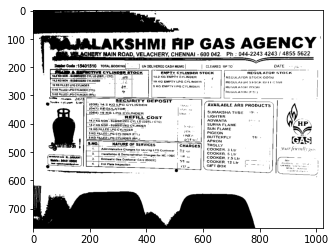

AKSHMI AP GAS AGENCY

HERY MAIN ROAD, VELACHERY, CHENNAI - 600 042. Ph : 044-2243 4243 / 4855 5622

DATE

Damler-Cods 15401510 Total sooKns|” | UN DELIVERED cast MEMO |

| CLEARED ue To

i

CYLINDER STOCK

EMI

ey

DER STOCK

REGULATOR STOCK

+ GUBSDIZED C¥L LD (GATL CTC]

142 KOE!

ve!

DER

10

Zi

REGULATOR STOCK GOOD

"142 KG NON - SUBGIOMED CYLINDER

iL

19 KG EMPTY LPG CYLINDER

REGULAIOR S10CK DF

crow

LPG CYLINDE:

5G EMPTY IPG CYLINDER

REGULATOR FOTAL

‘SG FLLED LPO CYLNOER FTL)

aL

REGULATON (FTI)

Sx

5

INDER (RELY

~—_

sawn 2857

SECURITY DEPOSIT

et et “Siar

(036) 14.2 KG LPG CYLI

DER

bse

AVAILABLE ARB PRODUCTS

(047) REGULATOR

1

184) 19 KG LPG CY!

NDER

Vt00

SURAKSHA TUBE

ye.

REFILL Cost

LIGHTER

ADVANTA

te

:

242 KG Now SUBBDIFED C¥e.CO BTL! Cro}

HP)

| #42 kG NOW. suBsIDize0 CYLINDER

wae

SURYA FLAME

)

19 KG FILLEG LPG CYLINDER

SUN FLAME

5KG FILLED LPG CYLINDER (FTL)

18m

PIGEON

NZ’

vay

BUTTERFLY

ae.

EKG FILLED LPG CVLINOER (AFL)

HID 5m

A

In [ ]:
from glob import glob
extract_text = dict()
for file_path in glob("data/*.jpg"):
  
    file_name = file_path.split("/")[-1]
    print (file_path, file_name)
    img = set_image_dpi(file_path)
    img = cv2.imread("improved.png")
    print (img.dtype)
#     img, coord = skew_correction(img)
    img = remove_noise_and_smooth(img[:,:,1])
    result = tesseratc_engine(img)
    extract_text[file_name] = result
  
  ##using easyocr
# print (result)
plt.imshow(img, cmap='gray')
plt.show()
print (result)

In [ ]:
label = {'3.jpg' : 'aadhar',
         '7.jpg' : 'aadhar',
         '4.jpg' : 'aadhar',
         '1.jpg' : 'aadhar',
         '6.jpg' : 'aadhar',
         '2.jpg' : 'aadhar',
         '5.jpg' : 'aadhar',
         'Incorrect Name.jpg' : 'Voter ID',
         'Incorrect details -1.jpg' : 'Driving Licence',
         'No details extracted.jpg' : 'Voter ID',
         '10049027336340_DrivingLicence.jpg' : 'Driving Licence',
         '10006989389712_VoterID.jpg' : 'Voter ID',
         '10018765037077_VoterID.jpg' : 'Voter ID',
         '10018657562676_VoterID.JPG' : 'Voter ID',
         '10057927394633_VoterID.jpg' : 'Voter ID',
         '20024075943716_AadharCard.jpg' : 'aadhar',
         '40089856771173_VoterID.jpg' : 'Voter ID',
         '30056250280226_VoterID.jpg' : 'Voter ID',
         '30052359236448_VoterID.jpg' : 'Voter ID',
         '10009952427392_VoterID.JPG' : 'Voter ID',
         'No details extracted - 2.jpg' : 'Driving Licence',
         'Cropped.jpg' : 'Voter ID',
         'Voter9_Front.jpg' : 'Voter ID',
         'Pratyoosh_Election1.jpg' : 'Voter ID',
         '49_DLFront.jpg' : 'Driving Licence',
         '13.jpg' : 'Voter ID',
         '9.jpg' : 'Voter ID',
         '10.jpg' : 'Voter ID',
         '11.jpg' : 'Voter ID',
         '14.JPG' : 'Voter ID',
         '18.jpg' : 'Voter ID',
         '8.jpg' : 'Voter ID',
         '17.jpg' : 'Voter ID',
         '15.JPG' : 'Voter ID',
         '45.jpg' : 'Driving Licence',
         '52.jpg' : 'Driving Licence',
         '34.jpg' : 'Driving Licence',
         '37.jpg' : 'Driving Licence',
         '42.jpg' : 'Driving Licence',
         '41.jpg' : 'Driving Licence',
         '30.jpg' : 'Driving Licence',
         '48.jpg' : 'Driving Licence',
         '43.jpg' : 'Driving Licence',
         '40.jpg' : 'Driving Licence',
         '26.jpg' : 'Driving Licence',
         '28.JPG' : 'Driving Licence',
         '31.jpg' : 'Driving Licence',
         '39.jpg' : 'Driving Licence',
         '38.jpg' : 'Driving Licence',
         '49.jpg' : 'Driving Licence',
         '44.jpg' : 'Driving Licence',
         '33.jpg' : 'Driving Licence',
         '50.jpg' : 'Driving Licence',
         '36.jpg' : 'Driving Licence',
         '47.jpg' : 'Driving Licence',
         '27.jpg' : 'Driving Licence',
         '51.jpg' : 'Driving Licence',
         '35.jpg' : 'Driving Licence',
         'PAN-Card-Sample.jpg' : 'Pan Card',
         'gas bill 1.jpg' : 'Gas Bill',
         'gas bill 2.jpg' : 'Gas Bill',
         'gas bill 3.jpg' : 'Gas Bill',
         'gas bill 4.jpg' : 'Gas Bill',
         'gas bill 5.jpg' : 'Gas Bill',
         'gas bill 6.jpg' : 'Gas Bill',
         'gas bill 7.jpg' : 'Gas Bill',
         'gas bill 8.jpg' : 'Gas Bill',
         'gas bill 9.jpg' : 'Gas Bill',
         'gas bill 10.jpg' : 'Gas Bill',
         'pp 1.jpg' : 'PassPort',
         'pp 2.jpg' : 'PassPort',
         'pp 4.jpg' : 'PassPort',
         'pp 5.jpg' : 'PassPort',
         'pp 7.jpg' : 'PassPort',
         'pp 8.jpg' : 'PassPort',
         'pp 10.jpg' : 'PassPort'

        }

In [ ]:
train_df = pd.DataFrame(columns = ['img','text','label'])
j = 0
for k,v in zip(extract_text.keys(), label.keys()):
    try:
        train_df.loc[j,'label'] = label[k.split("\\")[-1]]
        train_df.loc[j,'img'] = k.split("\\")[-1]
        train_df.loc[j,'text'] = extract_text[k]

        j += 1
    except Exception as e:
        print (e)

In [ ]:
for i, row in train_df.iterrows():
    text = ""
    for t in row[0]:    
        text = text + "\n" + t[0]
    train_df.loc[i,'filtered_text'] = text

In [ ]:
type(extract_text)

dict

In [ ]:
for i in extract_text.keys():
    text = ""
    for t in row[1]:    
        text = text + "\n" + t[0]
    extract_text = text

SyntaxError: ignored

In [ ]:
text = ""
for t in result:    
    text = text + "\n" + t[0]
text

'\nA\nK\nS\nH\nM\nI\n \nA\nP\n \nG\nA\nS\n \nA\nG\nE\nN\nC\nY\n\n\n\n\nH\nE\nR\nY\n \nM\nA\nI\nN\n \nR\nO\nA\nD\n,\n \nV\nE\nL\nA\nC\nH\nE\nR\nY\n,\n \nC\nH\nE\nN\nN\nA\nI\n \n-\n \n6\n0\n0\n \n0\n4\n2\n.\n \nP\nh\n \n:\n \n0\n4\n4\n-\n2\n2\n4\n3\n \n4\n2\n4\n3\n \n/\n \n4\n8\n5\n5\n \n5\n6\n2\n2\n\n\n\n\nD\nA\nT\nE\n\n\n\n\nD\na\nm\nl\ne\nr\n-\nC\no\nd\ns\n \n1\n5\n4\n0\n1\n5\n1\n0\n \nT\no\nt\na\nl\n \ns\no\no\nK\nn\ns\n|\n”\n \n|\n \nU\nN\n \nD\nE\nL\nI\nV\nE\nR\nE\nD\n \nc\na\ns\nt\n \nM\nE\nM\nO\n \n|\n\n\n\n\n|\n \nC\nL\nE\nA\nR\nE\nD\n \nu\ne\n \nT\no\n\n\n\n\ni\n\n\n\n\nC\nY\nL\nI\nN\nD\nE\nR\n \nS\nT\nO\nC\nK\n\n\n\n\nE\nM\nI\n\n\n\n\ne\ny\n\n\n\n\nD\nE\nR\n \nS\nT\nO\nC\nK\n\n\n\n\nR\nE\nG\nU\nL\nA\nT\nO\nR\n \nS\nT\nO\nC\nK\n\n\n\n\n+\n \nG\nU\nB\nS\nD\nI\nZ\nE\nD\n \nC\n¥\nL\n \nL\nD\n \n(\nG\nA\nT\nL\n \nC\nT\nC\n]\n\n\n\n\n1\n4\n2\n \nK\nO\nE\n!\n\n\n\n\nv\ne\n!\n\n\n\n\nD\nE\nR\n\n\n\n\n1\n0\n\n\n\n\nZ\ni\n\n\n\n\nR\nE\nG\nU\nL\nA\nT\nO\nR\n \nS\nT\nO\nC\nK\n \nG\nO\nO\n

## Text Processing

In [ ]:
import re

In [ ]:
m = iter(zip(train_df['filtered_text'].values, train_df['img'].values))

In [ ]:
ss = ['dataset\\l_pancard-farzi-1499313521_835x547.jpg_thump.jpg',
 'dataset\\pan-card-service-352.jpg',
 'dataset\\PAN-CARD.jpg',
 'dataset\\pan.jpg',
 'dataset\\Sample-PAN-Card-Barack-Obama.jpg',
 'dataset\\wealth-space-velacheri-chennai-pan-card-consultants-2cofbuh-250.jpg']
remove = []
for keys in extract_text.keys():
    if keys in ss:
        pass
    else:
        remove.append(keys)
        
for k in remove:
    extract_text.pop(k)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-f123f6682227>", line 8, in <module>
    for keys in extract_text.keys():
AttributeError: 'str' object has no attribute 'keys'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6/dist-packa

AttributeError: ignored

In [ ]:
result = extract_text[k]
# m = iter(extract_text.keys())


In [ ]:
# voterid = '(electo|lection|commis|commisiom|election|electioncommission)$'
# test = 'Electors Name: Sonal Suryakant Khot'.lower().split()[0]
# re.search(voterid, test).group(1)

In [ ]:
import re

In [ ]:
def detect_document(word):
    
    voterid = '(lllciioncommissionov|elect|lection|commis|commisiom|election|electioncommission)$'
    
    if re.search(voterid, word.lower().split()[0]):
        print (word.lower())
        return 'Voter ID'
    elif 'aadhar' in word.lower():
        return 'Aadhar'
    elif ('driving' in word.lower() or ('transport' in word.lower()) 
         or ('veihcles' in word.lower()) or ('motor' in word.lower())
         or ('valid' in word.lower()) or ('vald' in word.lower())
         or ('licence' in word.lower())):
        return 'Driving License'
    else:
        return None

In [ ]:
def clean_text(text):
    text = text.replace("#","H")
    
    return text

In [ ]:
founda = 0
foundn = 0
prediction = []
for word in result.split("\n"):
#     print (word)
    word = clean_text(word)
    
     ### if the word is alpha
    if word.replace(" ","").isalpha() and founda == 0 :
        print ("1===============>", word.lower())
        if detect_document(word):
            prediction = prediction + [detect_document(word)]
            founda = 1

    elif word.replace(" ","").isdigit() and foundn == 0:
        word = word.replace(" ","")
        print ("NUmmmmmmmmm",word)
        if 10 < len(word) <= 12:
            prediction = prediction + ["Aadhar"]
            
        elif len(word) > 14 :
            prediction = prediction + ["Driving License"]
    else:
        pass
#         print (word)
print ("the card is ", prediction)

1===============> election commission of india
election commission of india
election commission of india
the card is  ['Voter ID']


In [ ]:
print (extract_text['data\\10.jpg'])

ELECTION COMMISSION OF INDIA

IDENTITY CARD

Ra

arm

Wart TF

MzH2380426

at

~

Recor Name

fretew wt en: eer

Fatece Nae

BRL BHUSHAN.

fem 332

rr

sex) en

FEMALE! ef)

pavesén (120-38 Yeon

